# sklearn.linear_model.Lasso
- Linear Model trained with L1 prior as regularizer (aka the Lasso)

- The optimization objective for Lasso is:
$ (\frac{1} {(2 * n_samples)}) * ||y - Xw||^2_2 + alpha * ||w||_1$ 
- Technically the Lasso model is optimizing the same objective function as the Elastic Net with l1_ratio=1.0 (no L2 penalty).

In [1]:
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from yellowbrick.model_selection import ValidationCurve
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import AlphaSelection
from yellowbrick.regressor import ManualAlphaSelection

In [2]:
Data=pd.read_csv('140_crash.csv')
Data=Data[0:130]

Head = Data.columns[14]
Chest_deflection =  Data.columns[13]
Head_acceleration = Data.columns[15]
neck_force = Data.columns[16]

X=Data[Data.columns[0:13]]
y=Data[Chest_deflection]

In [6]:
Data[Head_acceleration].skew()

1.0928335788962298

# Validation curves

# alpha
- float, default=1.0
- Constant that multiplies the L1 term. Defaults to 1.0. alpha = 0 is equivalent to an ordinary least square, solved by the LinearRegression object. For numerical reasons, using alpha = 0 with the Lasso object is not advised. Given this, you should use the LinearRegression object.

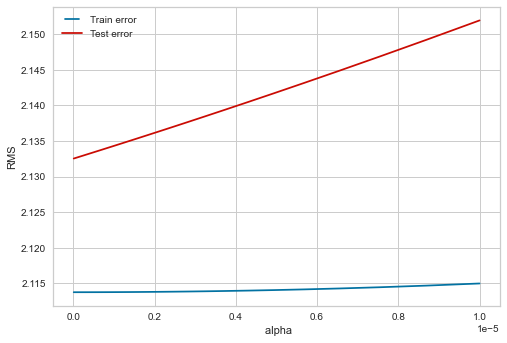

In [27]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
learning_rates =  np.logspace(-8, -5, 50)
train_results = []
test_results = []
for eta in learning_rates:
    model = Lasso(alpha=eta)
    model.fit(x_train, y_train)
    train_pred = model.predict(x_train)
    ax=mean_squared_error(y_train, train_pred,squared=False)
    train_results.append(ax)
    y_pred = model.predict(x_test)
    ax=mean_squared_error(y_test, y_pred,squared=False)
    test_results.append(ax)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(learning_rates, train_results, 'b', label="Train error")
line2, = plt.plot(learning_rates, test_results, 'r', label="Test error")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('RMS')
plt.xlabel(' alpha')
plt.show()

---
---

# Random Hyperparameter Grid

In [30]:
alpha = np.linspace(1e-06, 1e-05, 50, endpoint=True)
selection=['cyclic','random']
normalize=[True,False]
warm_start=[True,False]

random_grid = {"alpha" :alpha,
               "normalize":normalize,
               "warm_start":warm_start,
               "selection":selection}

In [32]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = Lasso()
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 200, cv = 10, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X,y)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 360 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    6.6s finished


RandomizedSearchCV(cv=10, estimator=Lasso(), n_iter=200, n_jobs=-1,
                   param_distributions={'alpha': array([1.00000000e-06, 1.18367347e-06, 1.36734694e-06, 1.55102041e-06,
       1.73469388e-06, 1.91836735e-06, 2.10204082e-06, 2.28571429e-06,
       2.46938776e-06, 2.65306122e-06, 2.83673469e-06, 3.02040816e-06,
       3.20408163e-06, 3.38775510e-06, 3.57142857e-06, 3.75510204e-06,
       3.93877551...
       6.87755102e-06, 7.06122449e-06, 7.24489796e-06, 7.42857143e-06,
       7.61224490e-06, 7.79591837e-06, 7.97959184e-06, 8.16326531e-06,
       8.34693878e-06, 8.53061224e-06, 8.71428571e-06, 8.89795918e-06,
       9.08163265e-06, 9.26530612e-06, 9.44897959e-06, 9.63265306e-06,
       9.81632653e-06, 1.00000000e-05]),
                                        'normalize': [True, False],
                                        'selection': ['cyclic', 'random'],
                                        'warm_start': [True, False]},
                   random_state=42, verb

In [33]:
rf_random.best_params_

{'warm_start': True, 'selection': 'random', 'normalize': False, 'alpha': 1e-05}

In [34]:
rf_random.best_estimator_

Lasso(alpha=1e-05, selection='random', warm_start=True)

In [36]:
#Chest
mod=Lasso(alpha=1e-05, selection='random', warm_start=True)

In [37]:
cv = KFold(n_splits=10, random_state=1)

C:\Users\ypyas\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [38]:
y_actual = []
predict = []
X, X_Test, y, y_Test = train_test_split(X, y, test_size=0.2, random_state=42)
train_size,train_score,test_score=learning_curve(mod,X,y,cv=cv,scoring='neg_root_mean_squared_error')


C:\Users\ypyas\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9117006405978236, tolerance: 0.02436416501792356
  model = cd_fast.enet_coordinate_descent(


<Figure size 576x396 with 0 Axes>

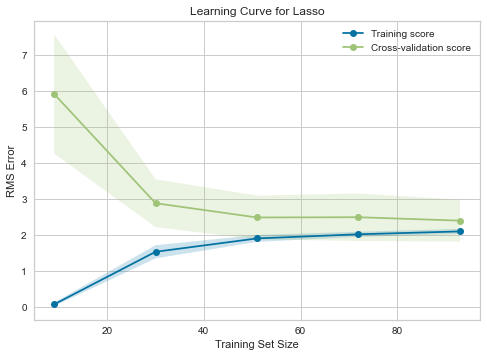

In [39]:

train_mean=-np.mean(train_score,axis=1)
train_std=-np.std(train_score,axis=1)
test_mean=-np.mean(test_score,axis=1)
test_std=-np.std(test_score,axis=1)
    
plt.figure()
plt.subplots(1)
plt.plot(train_size,train_mean, 'o-', color="b",label="Training score")
plt.plot(train_size, test_mean, 'o-', color="g",label="Cross-validation score")
plt.fill_between(train_size, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.fill_between(train_size, test_mean - test_std, test_mean + test_std, alpha=0.2)
plt.title("Learning Curve for {}".format(str(mod).split('(')[0]))
plt.xlabel("Training Set Size")
plt.ylabel("RMS Error")
plt.legend(loc="best")
plt.show()

In [40]:
X = X.to_numpy()
y = y.to_numpy()


In [41]:
y_Test=y_Test.to_numpy()

In [42]:
kf=cv

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    HBM_Train = mod.fit(X_train, y_train)
    HBM_Test = HBM_Train.predict(X_test)
    print('Root Mean squared error: %f'
          % mean_squared_error(y_test, HBM_Test,squared=False))
    print()

ytestunk=HBM_Train.predict(X_Test)
err=np.zeros(len(ytestunk))
for u in range (0,len(ytestunk)):
    err[u]=np.sqrt((y_Test[u]-ytestunk[u])**2)
a=pd.DataFrame(err).describe()
cov_r=a.loc['std']/abs(a.loc['mean'])
print("error COV--->{}  error mean --->{}  error std --->{}".format(cov_r,abs(a.loc['mean']),a.loc['std']))

Root Mean squared error: 2.542861

Root Mean squared error: 2.344506

Root Mean squared error: 2.229320

Root Mean squared error: 2.515406

Root Mean squared error: 2.777284

Root Mean squared error: 1.494925

Root Mean squared error: 2.547591

Root Mean squared error: 3.654557

Root Mean squared error: 1.540542

Root Mean squared error: 2.268996

error COV--->0    0.913798
dtype: float64  error mean --->0    1.578049
Name: mean, dtype: float64  error std --->0    1.442019
Name: std, dtype: float64


# train score

In [43]:
ytestunk=HBM_Train.predict(X)
err=np.zeros(len(ytestunk))
for u in range (0,len(ytestunk)):
    err[u]=np.sqrt((y[u]-ytestunk[u])**2)
a=pd.DataFrame(err).describe()
cov_r=a.loc['std']/abs(a.loc['mean'])
print("error COV--->{}  error mean --->{}  error std --->{}".format(cov_r,abs(a.loc['mean']),a.loc['std']))

error COV--->0    0.8102
dtype: float64  error mean --->0    1.659333
Name: mean, dtype: float64  error std --->0    1.344391
Name: std, dtype: float64


---
---

# Grid search

In [68]:
alpha = np.linspace(1e-06, 1e-03, 100, endpoint=True)
selection=['cyclic','random']
normalize=[True,False]
warm_start=[True,False]

random_grid = {"alpha" :alpha,
               "normalize":normalize,
               "warm_start":warm_start,
               "selection":selection}

In [78]:
Data=pd.read_csv('140_crash.csv')
Data=Data[0:130]

Head = Data.columns[14]
Chest_deflection =  Data.columns[13]
Head_acceleration = Data.columns[15]
neck_force = Data.columns[16]

X=Data[Data.columns[0:13]]
y=Data[Head]

In [79]:
rf = Lasso()
reg = GridSearchCV(rf,param_grid = random_grid ,cv = cv, return_train_score=True,scoring="neg_root_mean_squared_error", verbose=2, n_jobs = -1)
reg.fit(X,y)
    

Fitting 10 folds for each of 800 candidates, totalling 8000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1032 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 4280 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 7908 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 8000 out of 8000 | elapsed:    9.6s finished


GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=False),
             estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-06, 1.10909091e-05, 2.11818182e-05, 3.12727273e-05,
       4.13636364e-05, 5.14545455e-05, 6.15454545e-05, 7.16363636e-05,
       8.17272727e-05, 9.18181818e-05, 1.01909091e-04, 1.12000000e-04,
       1.22090909e-04, 1.32181818e-04, 1.42272727e-04, 1.5236...
       8.48636364e-04, 8.58727273e-04, 8.68818182e-04, 8.78909091e-04,
       8.89000000e-04, 8.99090909e-04, 9.09181818e-04, 9.19272727e-04,
       9.29363636e-04, 9.39454545e-04, 9.49545455e-04, 9.59636364e-04,
       9.69727273e-04, 9.79818182e-04, 9.89909091e-04, 1.00000000e-03]),
                         'normalize': [True, False],
                         'selection': ['cyclic', 'random'],
                         'warm_start': [True, False]},
             return_train_score=True, scoring='neg_root_mean_squared_error',
             verbose=2)

In [81]:
reg.best_estimator_

Lasso(alpha=0.00045509090909090917, selection='random')

In [21]:
Data=pd.read_csv('140_crash.csv')
Data=Data[0:130]

Head = Data.columns[14]
Chest_deflection =  Data.columns[13]
Head_acceleration = Data.columns[15]
neck_force = Data.columns[16]

X=Data[Data.columns[0:13]]
y=Data[Chest_deflection]

In [22]:
#Chest
mod=Lasso(alpha=2.1181818181818184e-05, warm_start=True)
# Neck
# mod=Lasso(alpha=1e-06, selection='random')
#Head acc
# mod=Lasso(alpha=0.0006064545454545455, normalize=True, selection='random',warm_start=True)
#HIC
# mod=Lasso(alpha=0.00045509090909090917, selection='random')

In [23]:
cv = KFold(n_splits=10, random_state=1)

C:\Users\ypyas\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [24]:
y_actual = []
predict = []
# X, X_Test, y, y_Test = train_test_split(X, y, test_size=0.2, random_state=42)
train_size,train_score,test_score=learning_curve(mod,X,y,cv=cv,scoring='neg_mean_absolute_error')
kf=cv

## Learning Curve

<Figure size 576x396 with 0 Axes>

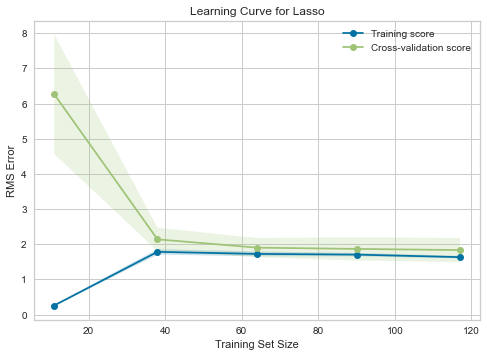

In [25]:
train_mean=-np.mean(train_score,axis=1)
train_std=-np.std(train_score,axis=1)
test_mean=-np.mean(test_score,axis=1)
test_std=-np.std(test_score,axis=1)
    
plt.figure()
plt.subplots(1)
plt.plot(train_size,train_mean, 'o-', color="b",label="Training score")
plt.plot(train_size, test_mean, 'o-', color="g",label="Cross-validation score")
plt.fill_between(train_size, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.fill_between(train_size, test_mean - test_std, test_mean + test_std, alpha=0.2)
plt.title("Learning Curve for {}".format(str(mod).split('(')[0]))
plt.xlabel("Training Set Size")
plt.ylabel("RMS Error")
plt.legend(loc="best")
plt.show()

In [26]:
pd.DataFrame(test_mean)

,0
0,6.270558
1,2.141493
2,1.905483
3,1.869639
4,1.836311


## Unknown data test

In [46]:
X = X.to_numpy()
y = y.to_numpy()
y_Test=y_Test.to_numpy()
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    HBM_Train = mod.fit(X_train, y_train)
    HBM_Test = HBM_Train.predict(X_test)
    print('Root Mean squared error: %f'
          % mean_squared_error(y_test, HBM_Test,squared=False))
    print()

ytestunk=HBM_Train.predict(X_Test)
err=np.zeros(len(ytestunk))
for u in range (0,len(ytestunk)):
    err[u]=np.sqrt((y_Test[u]-ytestunk[u])**2)
a=pd.DataFrame(err).describe()
cov_r=a.loc['std']/abs(a.loc['mean'])
print("error COV--->{}  error mean --->{}  error std --->{}".format(cov_r,abs(a.loc['mean']),a.loc['std']))

Root Mean squared error: 0.234120

Root Mean squared error: 0.145244

Root Mean squared error: 0.162970

Root Mean squared error: 0.155707

Root Mean squared error: 0.177626

Root Mean squared error: 0.216819

Root Mean squared error: 0.134655

Root Mean squared error: 0.149634

Root Mean squared error: 0.127077

Root Mean squared error: 0.162844

error COV--->0    0.929088
dtype: float64  error mean --->0    0.118004
Name: mean, dtype: float64  error std --->0    0.109637
Name: std, dtype: float64


# train score

In [47]:
ytr=HBM_Train.predict(X)
err=np.zeros(len(ytr))
for u in range (0,len(ytr)):
    err[u]=np.sqrt((y[u]-ytr[u])**2)
a=pd.DataFrame(err).describe()
cov_r=a.loc['std']/abs(a.loc['mean'])
print("error COV--->{}  error mean --->{}  error std --->{}".format(cov_r,abs(a.loc['mean']),a.loc['std']))

error COV--->0    0.748861
dtype: float64  error mean --->0    0.119904
Name: mean, dtype: float64  error std --->0    0.089792
Name: std, dtype: float64


In [48]:
df_tosave=pd.DataFrame(ytestunk,columns = ['Unseen predicted'])
df_tosave['test actual']=pd.DataFrame(y_Test)
df_tosave.to_csv('Lassneckunseen.csv')

df_trn=pd.DataFrame(ytr,columns = ['train predicted'])
df_trn['actual']=pd.DataFrame(y)
df_trn.to_csv('Lassonecktrain.csv')